# 용해도 예측
- 물질이 용매에 포화상태까지 녹을 수 있는 한도 ( - log(solubility) measured in moles/liter)
- 머신러닝의 동작 이해 (X로부터 y를 예측하는 모델 이해)
- chemical formula(X)로부터 용해도(y)를 예측
- 알려진 실제 화합물의 용해도로부터,유사한 화합물의 용해도를 예측하는 데 사용

In [1]:
!pip install deepchem
import deepchem as dc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 5.2 MB/s 
     |████████████████████████████████| 36.8 MB 36 kB/s 


In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs

import tempfile
from itertools import islice
from IPython.display import Image, display
from deepchem.utils.data_utils import load_from_disk 
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

# 데이터 파일 가져오기
- 분자 SMILES, 용해도 등 분자 특성을 포함한 데이터 csv 파일 다운로드
- 파일 다운로드 : wget or curl 사용
- 존 델라니가 2004년에 발표한 논문 데이터 파일 사용

In [3]:
!wget https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv

--2022-10-12 10:08:24--  https://raw.githubusercontent.com/deepchem/deepchem/master/datasets/delaney-processed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 96699 (94K) [text/plain]
Saving to: ‘delaney-processed.csv’

delaney-processed.c 100%[===================>]  94.43K  --.-KB/s    in 0.01s   

2022-10-12 10:08:24 (6.60 MB/s) - ‘delaney-processed.csv’ saved [96699/96699]



In [4]:
# load_from_disk() : pandas read_csv()와 같은 역할 함수 (데이터프레임)
from deepchem.utils.data_utils import load_from_disk  

dataset = load_from_disk("delaney-processed.csv")
print(dataset.shape)
dataset[:3]

(1128, 10)


,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.77,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.30,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.06,CC(C)=CCCC(C)=CC(=O)


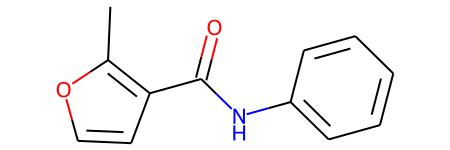

In [9]:
# mol 객체에서 1개 분자 이미지 출력
Chem.MolFromSmiles(dataset["smiles"][1])

In [5]:
# 여러 개 분자의 이미지를 출력하려면 파일들을 출력하는 함수를 정의해야 함
def display_images(filenames):
    for file in filenames:
      display(Image(file))

# mol 객체들을 입력으로 받아 이미지 파일을 만들고 파일의 리스트를 리턴하는 함수
# test0.png, test1.png 등으로 생성

def mols_to_pngs(mols, basename="test"):
    filenames = []
    for i, mol in enumerate(mols):
        # filename = "%s%d.png" % (basename, i)
        filename = basename+str(i)+".png"
        Draw.MolToFile(mol, filename)
        filenames.append(filename)
    return filenames

In [6]:
# 읽은 dataset에서 N개 분자들을 이미지로 시각화
num_to_display = 3  
molecules = []
for _, data in islice(dataset.iterrows(), num_to_display):
    molecules.append(Chem.MolFromSmiles(data["smiles"]))

molecules

In [7]:
# 이미지 파일 만들기    
f_names = mols_to_pngs(molecules)
f_names

['test0.png', 'test1.png', 'test2.png']

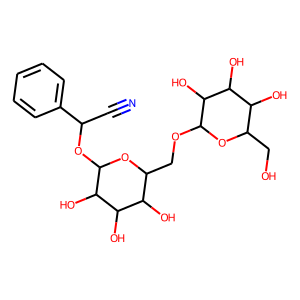

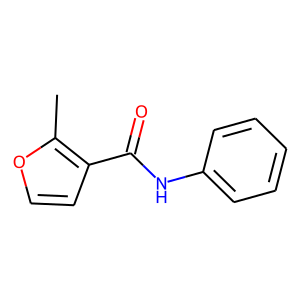

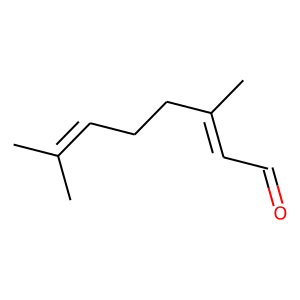

In [8]:
# 이미지 파일 출력하기
display_images(f_names)

# 용해도 구하기

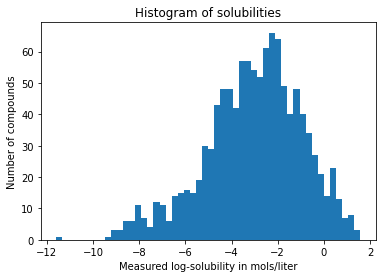

In [10]:
solubilities = np.array(dataset["measured log solubility in mols per litre"])
plt.hist(solubilities, 50)
plt.xlabel('Measured log-solubility in mols/liter')
plt.ylabel('Number of compounds')
plt.title('Histogram of solubilities')
plt.show()

# 화합물의 특성들을 featurization하기(특성화)
- SMILES로부터 특성값을 생성하는 방법으로 ECPF를 사용
- CSVLoader 클래스의 featurize()를 사용한다
 - dc.feat 모듈의 CircularFingerprint 클래스 사용
- create_dataset()으로 DiskDataset을 만든다
 - X, y, w, task, ids 등을 포함하는 데이터셋

In [11]:
featurizer = dc.feat.CircularFingerprint(size=1024)
loader = dc.data.CSVLoader(
      tasks=["measured log solubility in mols per litre"], feature_field="smiles",
      featurizer=featurizer)
data_FP = loader.create_dataset("delaney-processed.csv")

In [12]:
data_FP

<DiskDataset X.shape: (1128, 1024), y.shape: (1128, 1), w.shape: (1128, 1), task_names: ['measured log solubility in mols per litre']>

In [14]:
print(data_FP.X[0,:30])
print(data_FP.y[:5])
print(data_FP.w[:5])
print(data_FP.ids[:5])

[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[[-0.77]
 [-3.3 ]
 [-2.06]
 [-7.87]
 [-1.33]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]
['OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)C(O)C3O '
 'Cc1occc1C(=O)Nc2ccccc2' 'CC(C)=CCCC(C)=CC(=O)'
 'c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43' 'c1ccsc1']


# 데이터 분할하기
- dc.splits에서 다양한 분할 방법을 제공
-  ScaffoldSplitter 함수를 사용

In [16]:
splitter = dc.splits.ScaffoldSplitter()
train_dataset, valid_dataset, test_dataset = splitter.train_valid_test_split(data_FP)

In [17]:
train_dataset.ids[:5]

array(['CC(C)=CCCC(C)=CC(=O)', 'CCCC=C', 'CCCCCCCCCCCCCC', 'CC(C)Cl',
       'CCC(C)CO'], dtype=object)

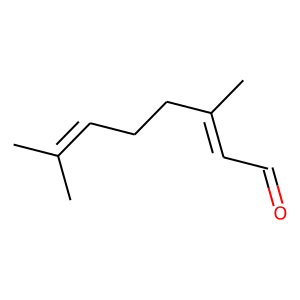

In [19]:
# 시각화 함수를 사용하여 일부 Train 데이터 시각화
train_mols = [Chem.MolFromSmiles(compound)
              for compound in train_dataset.ids]
display_images(mols_to_pngs(train_mols[:1], basename="train"))

# 데이터 스케일링하기

In [20]:
# 표준 스케일링 수행
transformers = [
dc.trans.NormalizationTransformer(transform_y=True, dataset=train_dataset)]

for dataset in [train_dataset, valid_dataset, test_dataset]:
  for transformer in transformers:
      dataset = transformer.transform(dataset)

In [21]:
train_dataset

<DiskDataset X.shape: (902, 1024), y.shape: (902, 1), w.shape: (902, 1), ids: ['CC(C)=CCCC(C)=CC(=O)' 'CCCC=C' 'CCCCCCCCCCCCCC' ...
 'Nc2cccc3nc1ccccc1cc23 ' 'C1CCCCCC1' 'OC1CCCCCC1'], task_names: ['measured log solubility in mols per litre']>

# 머신러닝 모델 만들기
- deepChem은 SklearnModel을 통해서 scikit-learn 의 모델들도 지원함

In [22]:
from sklearn.ensemble import RandomForestRegressor
sklearn_model = RandomForestRegressor()

# sklearn 모델을 deepchem models로 변경
model = dc.models.SklearnModel(sklearn_model)

#train_dataset에 포함된 X, w, y값을 사용하여 모델 훈련
model.fit(train_dataset)

# 머신러닝 모델 성능 평가
- deepchem의 Evaluator 객체의 compute_model_performance()로 평가함

In [23]:
from deepchem.utils.evaluate import Evaluator
metric1 = dc.metrics.Metric(dc.metrics.r2_score)
metric2 = dc.metrics.Metric(dc.metrics.rms_score)

evaluator = Evaluator(model, valid_dataset, transformers)
scores = evaluator.compute_model_performance([metric1, metric2])
print(scores)

{'r2_score': 0.139912739108094, 'rms_score': 3.7889981763091387}


# 모델 최적화
- 하이퍼파라미터 튜닝 수행

In [26]:
#하이퍼파라미터의 여러개의 값 설정 
params_dict = {
    "n_estimators": [50, 100],
    "max_features": [0.1, 0.15, 0.2],
    "max_depth" : [17, 19, 21]
}

def rf_model_builder(n_estimators, max_features, max_depth, model_dir):
  sklearn_model = RandomForestRegressor(
      n_estimators=n_estimators, max_features=max_features, max_depth=max_depth)
  return dc.models.SklearnModel(sklearn_model, model_dir)

metric = dc.metrics.Metric(dc.metrics.r2_score)
optimizer = dc.hyper.GridHyperparamOpt(rf_model_builder)

# 최고 성능의 모델, 최고 성능의 하이퍼파라미터, 모든 결과를 리턴
best_rf, best_rf_hyperparams, all_rf_results = optimizer.hyperparam_search(
    params_dict, train_dataset, valid_dataset, metric, transformers)

In [27]:
#최고 성능을 보이는 모델 하이퍼파라미터 출력
print(best_rf)

#최적 하이퍼파라미터 값 출력
print(best_rf_hyperparams)

#모든 탐색 성능 평가 결과 출력
print(all_rf_results)

{'n_estimators': 50, 'max_features': 0.1, 'max_depth': 21}
{'_max_depth_17_max_features_0.100000_n_estimators_50': 0.22676975056770765, '_max_depth_19_max_features_0.100000_n_estimators_50': 0.20758115178109815, '_max_depth_21_max_features_0.100000_n_estimators_50': 0.27013624988039775, '_max_depth_17_max_features_0.150000_n_estimators_50': 0.2345941448433465, '_max_depth_19_max_features_0.150000_n_estimators_50': 0.23653582305201581, '_max_depth_21_max_features_0.150000_n_estimators_50': 0.2327611528795338, '_max_depth_17_max_features_0.200000_n_estimators_50': 0.20295010756428078, '_max_depth_19_max_features_0.200000_n_estimators_50': 0.24238671836536463, '_max_depth_21_max_features_0.200000_n_estimators_50': 0.17552045044221132, '_max_depth_17_max_features_0.100000_n_estimators_100': 0.21342601064836475, '_max_depth_19_max_features_0.100000_n_estimators_100': 0.22002434785750546, '_max_depth_21_max_features_0.100000_n_estimators_100': 0.25469170388668605, '_max_depth_17_max_features

In [28]:
# 최대 value 찾기
print(max(all_rf_results.values()))

# 최대 value를 갖는 키 찾기
print(max(all_rf_results, key=all_rf_results.get))

0.27013624988039775
_max_depth_21_max_features_0.100000_n_estimators_50


# 그래프 컨볼루션 모델
- load_delaney() 함수를 사용하여 데이터를 다운로드하면서 featurizer 옵션을 선택
- mol_graphs.ConvMol 표현법을 선택함

In [30]:
# 데이터셋 구성
tasks, datasets, transformers = dc.molnet.load_delaney(featurizer='GraphConv')
train_dataset, valid_dataset, test_dataset = datasets

In [32]:
# 모델 만들기
model = dc.models.GraphConvModel(n_tasks=1, mode='regression', dropout=0.2)

# 학습하기 
model.fit(train_dataset, nb_epoch=100)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_14:0", shape=(348,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_13:0", shape=(348, 64), dtype=float32), dense_shape=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Cast_4:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/Reshape_17:0", shape=(1096,), dtype=int32), values=Tensor("gradient_tape/private__graph_conv_keras_model_1/graph_pool_3/

0.10552426338195801

In [33]:
# 성능평가
metric1 = dc.metrics.Metric(dc.metrics.pearson_r2_score)
metric2 = dc.metrics.Metric(dc.metrics.r2_score)

# 평가결과 출력
print("Training set score:", model.evaluate(train_dataset, [metric1, metric2], transformers))
print("Test set score:", model.evaluate(test_dataset, [metric1, metric2], transformers))

Training set score: {'pearson_r2_score': 0.9172464976613066, 'r2_score': 0.8959356277419099}
Test set score: {'pearson_r2_score': 0.6735734798081627, 'r2_score': 0.6344770398303157}


# 테스트 데이터로 용해도 예측하기

In [34]:
solubilities = model.predict_on_batch(test_dataset.X)
for molecule, solubility, test_solubility in zip(test_dataset.ids, solubilities, test_dataset.y):
    print(solubility, test_solubility, molecule)

[-2.081078] [-1.60114461] c1cc2ccc3cccc4ccc(c1)c2c34
[0.9827261] [0.20848251] Cc1cc(=O)[nH]c(=S)[nH]1
[-0.7689427] [-0.01602738] Oc1ccc(cc1)C2(OC(=O)c3ccccc23)c4ccc(O)cc4 
[-2.3116407] [-2.82191713] c1ccc2c(c1)cc3ccc4cccc5ccc2c3c45
[-1.7863467] [-0.52891635] C1=Cc2cccc3cccc1c23
[1.2813456] [1.10168349] CC1CO1
[-0.4334957] [-0.88987406] CCN2c1ccccc1N(C)C(=S)c3cccnc23 
[-1.0013402] [-0.52649706] CC12CCC3C(CCc4cc(O)ccc34)C2CCC1=O
[-1.5058892] [-0.76358725] Cn2cc(c1ccccc1)c(=O)c(c2)c3cccc(c3)C(F)(F)F
[0.1546126] [-0.64020358] ClC(Cl)(Cl)C(NC=O)N1C=CN(C=C1)C(NC=O)C(Cl)(Cl)Cl 
[0.03272122] [-0.38569452] COc2c1occc1cc3ccc(=O)oc23 
[0.36510673] [-0.62568785] CN2C(=C(O)c1ccccc1S2(=O)=O)C(=O)Nc3ccccn3 
[-0.1889596] [-0.39585553] Cc3cc2nc1c(=O)[nH]c(=O)nc1n(CC(O)C(O)C(O)CO)c2cc3C
[-1.2533407] [-2.05306753] c1ccc(cc1)c2ccc(cc2)c3ccccc3
[-0.37060273] [-0.29666474] CC34CC(=O)C1C(CCC2=CC(=O)CCC12C)C3CCC4(=O) 
[-1.0345168] [-0.73213651] c1ccc2c(c1)sc3ccccc23
[-1.1582675] [-1.27744393] CC23Cc1cnoc1C=C2

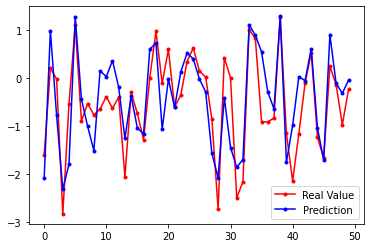

In [36]:
# 50개의 테스트 샘플로 용해도 예측 수행한 결과 그래프 그리기
plt.plot(test_dataset.y[:50], "r.-", label='Real Value')
plt.plot(solubilities[:50], "b.-",  label='Prediction')
plt.legend()

# 임의의 분자에 대해 용해도 예측해보기

In [37]:
smiles = ['COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C',
          'CCOC(=O)CC',
          'CSc1nc(NC(C)C)nc(NC(C)C)n1',
          'CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1',
          'Cc1cc2ccccc2cc1C']
mols = [Chem.MolFromSmiles(s) for s in smiles]
featurizer = dc.feat.ConvMolFeaturizer()
x = featurizer.featurize(mols)
predicted_solubility = model.predict_on_batch(x)
for m,s in zip(smiles, predicted_solubility):
    print()
    print('Molecule:', m)
    print('Predicted solubility:', s)


Molecule: COC(C)(C)CCCC(C)CC=CC(C)=CC(=O)OC(C)C
Predicted solubility: [-0.6664215]

Molecule: CCOC(=O)CC
Predicted solubility: [1.3979828]

Molecule: CSc1nc(NC(C)C)nc(NC(C)C)n1
Predicted solubility: [-0.09622876]

Molecule: CC(C#C)N(C)C(=O)Nc1ccc(Cl)cc1
Predicted solubility: [-0.33792895]

Molecule: Cc1cc2ccccc2cc1C
Predicted solubility: [-1.059375]
